## Example 2 - Computation with cubes from Sentinel Hub

This notebook shows how to write a **cube computation function** that is automatically **utilizing multiple threads**.

* Effectively mask cube data
* Develop and run a Python function to compute a new variable
* Compute Time-series, means, anomalies of new variable
* Inpect new variable in xcube viewer

To run this Notebook, make sure the SENTINEL Hub / xcube Integration is setup correctly, see [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [1]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
from xcube.core.compute import compute_cube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

In [2]:
%matplotlib inline

---
For this demo, we are focussing on small lake *Selenter See* near Kiel, Northern Germany (Baltic Sea):

In [3]:
x1 = 10.37  # degree
y1 = 54.28  # degree
x2 = 10.52  # degree
y2 = 54.33  # degree

bbox = x1, y1, x2, y2

In [4]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is 20 meters per pixel

In [5]:
spatial_res = 0.00018   # = 20.038 meters in degree

In [6]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2019-07-21', '2019-09-21'],
                         # time_tolerance='30M',
                         time_period='4D')

In [7]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 278, lon: 1024, time: 16)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-04-22T09:30:37.516749
    time_coverage_start:       2019-07-21T00:00:00+00:00
    time_coverage_end:         2019-09-23T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P4DT0H0M0S
    geospatial_lon_min:        10.37
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lat_max:        54.330040000000004
    processing_level:          L2A

The band `SCL` provides *scene classification flags*. Beause this "band" has a CF-compliant flag encodings in its metadata attributes, we can interpret them correctly:

In [8]:
scene_classif = MaskSet(cube.SCL)
scene_classif

Flag name,Mask,Value
no_data,None,0
saturated_or_defective,None,1
dark_area_pixels,None,2
cloud_shadows,None,3
vegetation,None,4
bare_soils,None,5
water,None,6
clouds_low_probability_or_unclassified,None,7
clouds_medium_probability,None,8
clouds_high_probability,None,9


xcube mask sets also follow data cube structure

In [9]:
scene_classif.cirrus

<xarray.DataArray 'cirrus' (time: 16, lat: 278, lon: 1024)>
dask.array<where, shape=(16, 278, 1024), dtype=uint8, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21

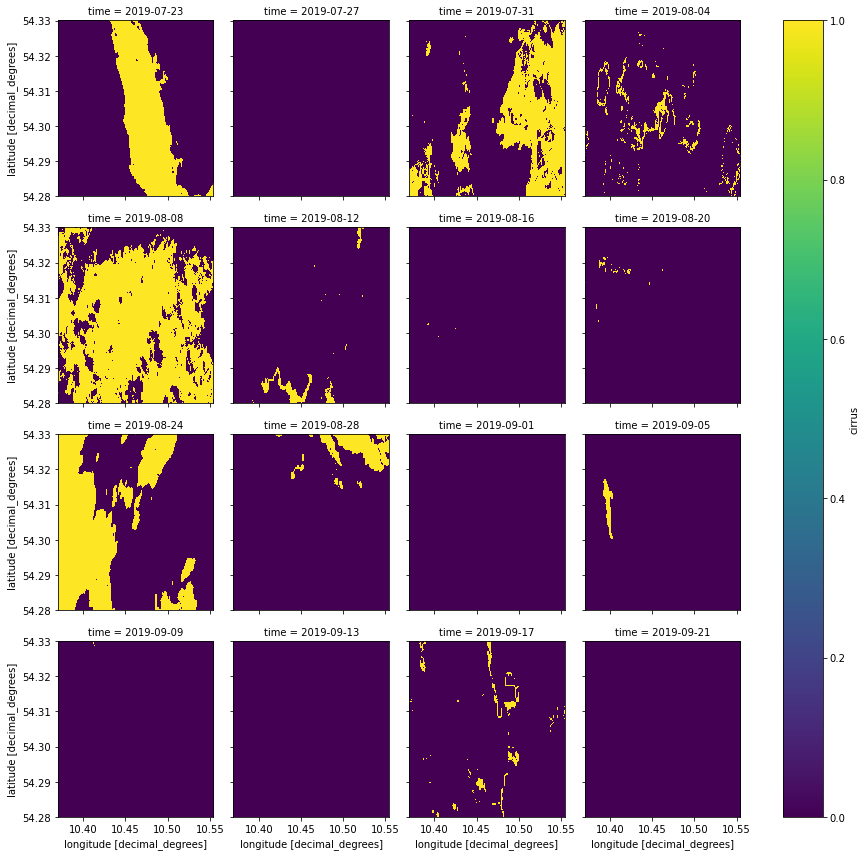

In [10]:
scene_classif.cirrus.plot.imshow(col='time', col_wrap=4, cmap='viridis')

We can use any of the mask or combinations of it to mask entire cubes. Here we create a "water cube":

In [11]:
water_cube = cube.where(scene_classif.water)
water_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 278, lon: 1024, time: 16)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-04-22T09:30:37.516749
    time_coverage_start:       2019-07-21T00:00:00+00:00
    time_coverage_end:         2019-09-23T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P4DT0H0M0S
    geospatial_lon_min:        10.37
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lat_max:        54.330040000000004
    processing_level:          L2A

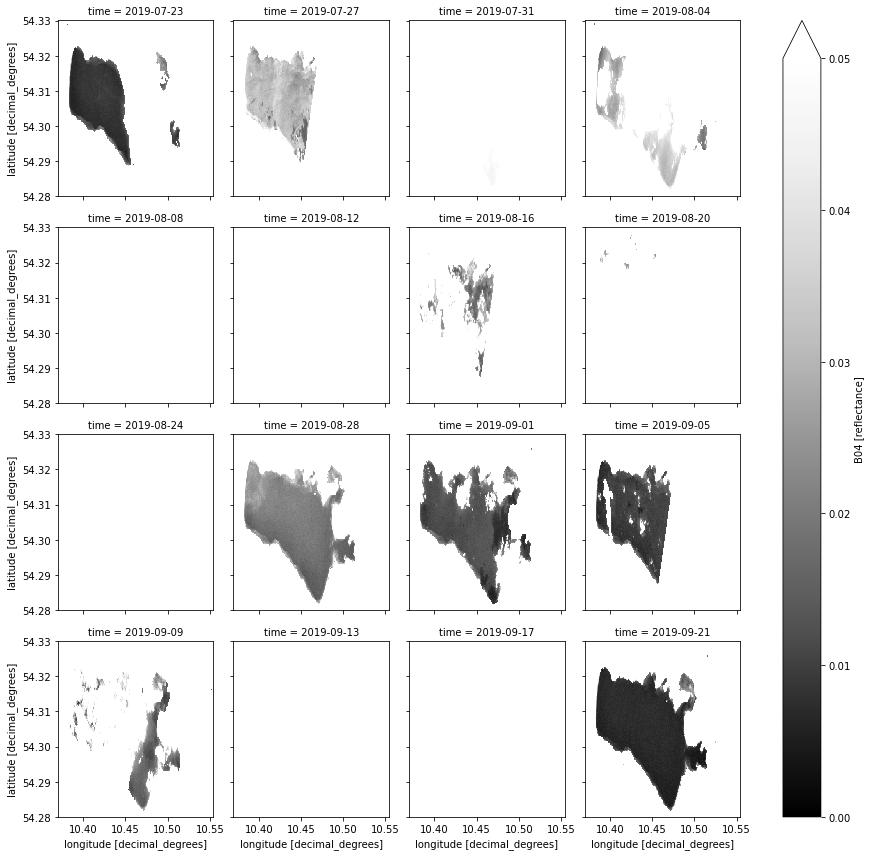

In [12]:
water_cube.B04.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=0.05, cmap='Greys_r')

---

We now compute a Chlorophyll indicator called *Maximum Chlorophyll Index* from bands B04, B05, B06. Note, it uses the wavelength for the bands as input parameters. 
The function is called for every *data chunk* in the cube returns a chunk for the variable to be computed. Chunks are computed independently and in parellel.

In [13]:
def compute_mci(b_from, b_peek, b_to, input_params, dim_coords):
    # The first three arguments are chunks of the three input variables we define below. 
    # You can name them as you like. They are pure 3D numpy arrays.
    
    # The 'input_params' argument is a standard parameter that we define in the call below.
    wlen_from = input_params['wlen_from']
    wlen_peek = input_params['wlen_peek']
    wlen_to = input_params['wlen_to']
    
    # The 'dim_coords' argument is optional and provides the coordinate values for all dimension 
    # of the current chunk. We don't use it here, but for many algorithms this is important 
    # information (e.g. looking up aux data).
    lon, lat = (dim_coords[dim] for dim in ('lon', 'lat'))
    # print('dim_coords from', lon[0], lat[0], 'to', lon[-1], lat[-1])
    
    # You can use any popular data packages such as numpy, scipy, dask here,
    # or we can use ML packages such as scikitlearn!
    # For simplity, we do some very simple array math here:

    f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
    mci = (b_peek - b_from) - f * (b_to - b_from)

    return mci

Prepare input parameters from band attributes:

In [14]:
input_params = dict(wlen_from=water_cube.B04.attrs['wavelength'],
                    wlen_peek=water_cube.B05.attrs['wavelength'],
                    wlen_to=water_cube.B06.attrs['wavelength'])
input_params

{'wlen_from': 664.75, 'wlen_peek': 703.95, 'wlen_to': 739.8}

In [15]:
mci_cube = compute_cube(compute_mci, 
                        water_cube, 
                        input_var_names=['B04', 'B05', 'B06'], 
                        input_params=input_params, 
                        output_var_name='mci')
mci_cube

d:\projects\xcube\xcube\core\compute.py:137: UserWarning: weird index_chunk of size 0 received!
  warnings.warn(f"weird index_chunk of size {index_chunk.size} received!")


<xarray.Dataset>
Dimensions:  (lat: 278, lon: 1024, time: 16)
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
Data variables:
    mci      (time, lat, lon) float64 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>

In [16]:
mci_cube.mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
mci_cube.mci.attrs['units'] = 'unitless'
mci_cube.mci

<xarray.DataArray 'mci' (time: 16, lat: 278, lon: 1024)>
dask.array<transpose, shape=(16, 278, 1024), dtype=float64, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
Attributes:
    long_name:  Maximum Chlorophyll Index
    units:      unitless

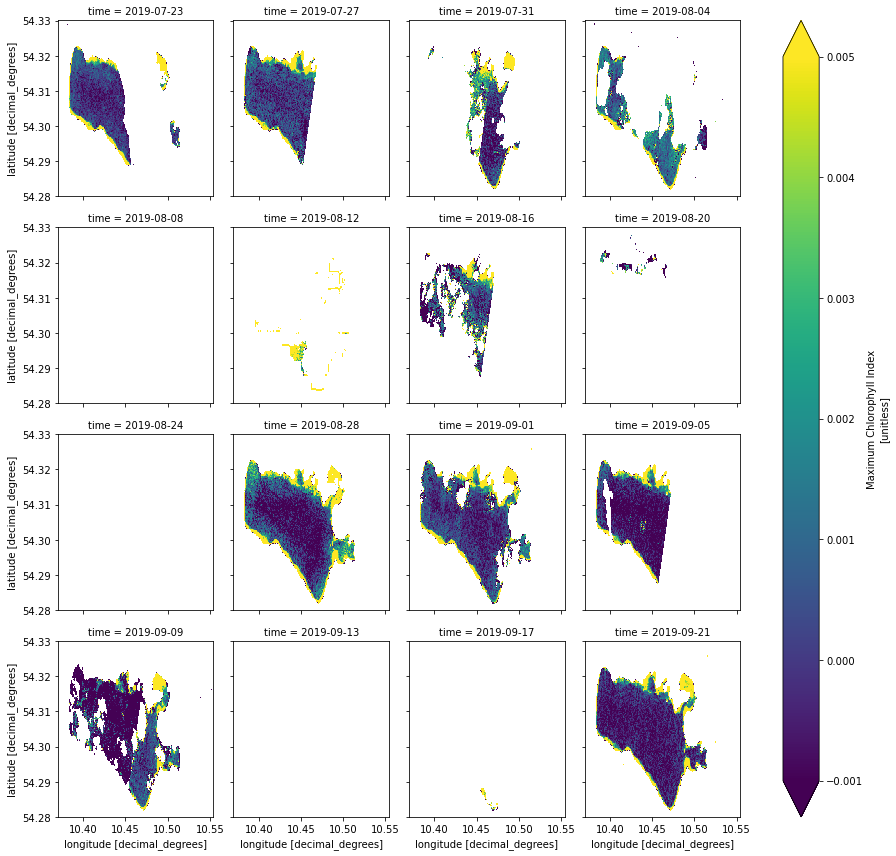

In [17]:
mci_cube.mci.plot.imshow(col='time', col_wrap=4, vmin=-0.001, vmax=0.005, cmap='viridis')

---

Time series at a given point:

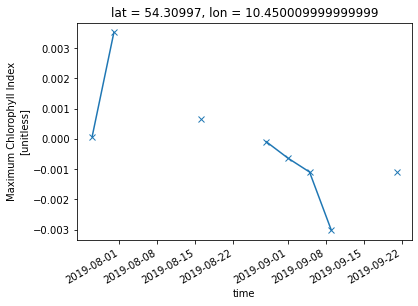

In [18]:
mci_cube.mci.sel(lat=54.31, lon=10.45, method='nearest').plot.line(marker='x')

Time series of the means of each time step:

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


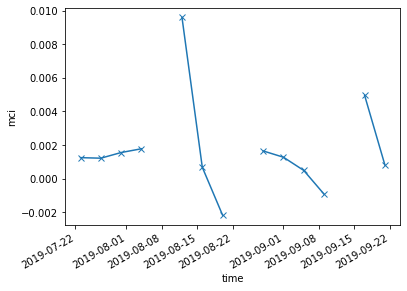

In [19]:
mci_cube.mci.mean(dim=('lat', 'lon'), skipna=True).plot.line(marker='x')

Mean of all time steps:

In [20]:
mci_mean = mci_cube.mci.mean(dim='time')

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


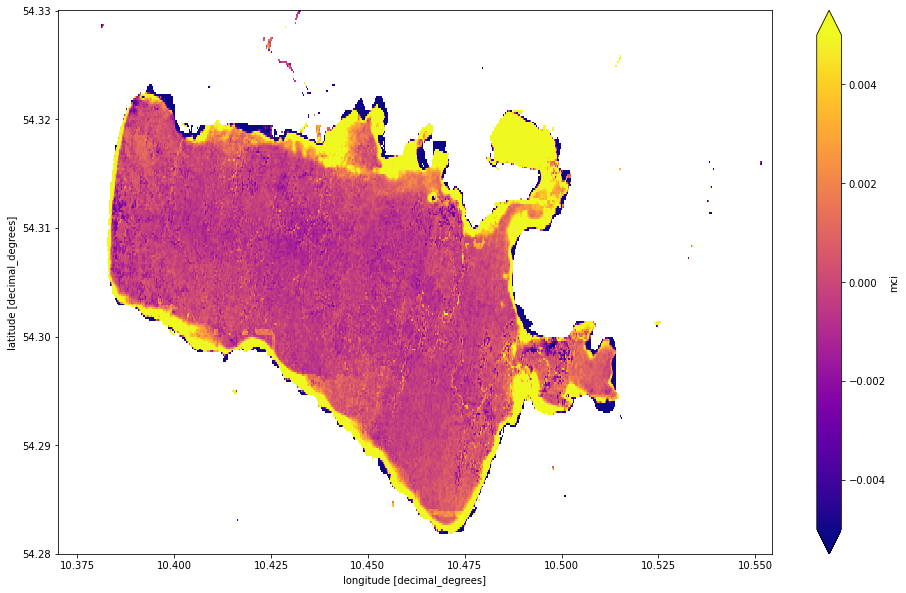

In [21]:
mci_mean.plot.imshow(vmin=-0.005, vmax=0.005, cmap='plasma', figsize=(16,10))

Anomaly w.r.t. to the mean for each time step:

In [22]:
mci_anomaly = mci_cube.mci - mci_mean

D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
D:\Miniconda3\envs\xcube\lib\site-packag

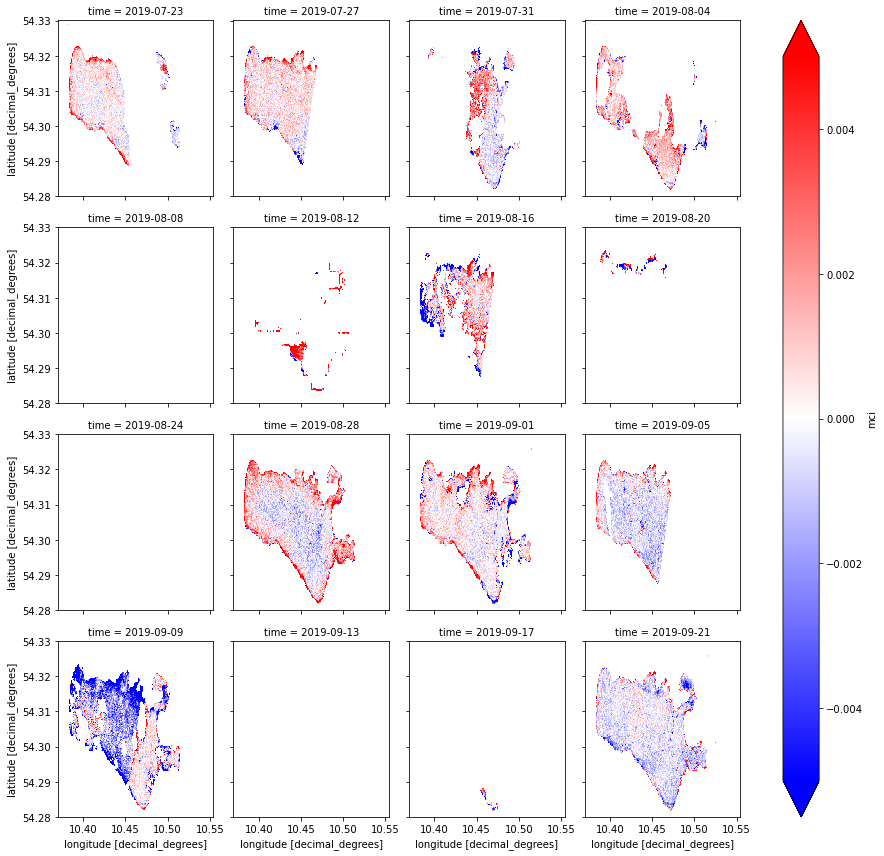

In [23]:
mci_anomaly.plot.imshow(col='time', col_wrap=4, vmin=-0.005, vmax=0.005, cmap='bwr')

---
Save the cube locally:

In [24]:
import shutil
shutil.rmtree('mci_cube.zarr', ignore_errors=True) # Delete, if already exists

In [25]:
mci_cube.to_zarr('mci_cube.zarr')

---
Inspect the saved cube in the [xcube Viewer](https://github.com/dcs4cop/xcube-viewer):

In [26]:
server = ViewerServer('mci_cube.zarr', server_url=None, styles=dict(mci=dict(vmin=-0.01, vmax=+0.01)))

opening new xcube server process: xcube serve --address 0.0.0.0 --port 8080 --styles mci=(-0.01,0.01,'viridis') mci_cube.zarr


In [27]:
server

Viewer:,Click to open
Server:,Click to open
Server PID:,None
PID:,15888
Process status:,Running


In [28]:
#server.kill()

In [29]:
# ViewerServer.kill_all()

In [30]:
ViewerServer.servers

Viewer:,Click to open
Server:,Click to open
Server PID:,None
PID:,15888
Process status:,Running
